In [14]:
%%capture --no-stderr
%pip install --quiet -U langgraph

In [15]:
from typing_extensions import TypedDict

class TypedDictState(TypedDict):
    foo: str
    bar: str

In [16]:
from IPython.display import Image, display

# MY EXAMPLE : 

## Made a basic Graph using Pydantic schema : 

In [17]:
# Cell 1: Imports and Pydantic State Definition
from langgraph.graph import StateGraph
from pydantic import BaseModel, validator
from typing import Literal

class DrinkState(BaseModel):
    name: str
    drink_choice: Literal["decide", "coffee", "tea"]
    
    @validator('drink_choice')
    def validate_choice(cls, v):
        if v not in ("decide", "coffee", "tea"):
            raise ValueError("drink_choice must be 'decide', 'coffee', or 'tea'")
        return v


/var/folders/g3/fm8vfsn162gbr3lvkzdfc_180000gn/T/ipykernel_19122/2214814510.py:10: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  @validator('drink_choice')


In [18]:
# Cell 2: Build the Graph
builder = StateGraph(DrinkState)

builder.add_node("decide", lambda s: print(f"Morning routine: {s.name}, choose coffee or tea."))
builder.add_node("coffee", lambda s: print(f"{s.name}, enjoy your coffee!"))
builder.add_node("tea", lambda s: print(f"{s.name}, enjoy your tea!"))

# Add conditional edges based on drink_choice
builder.add_conditional_edges("decide", 
    lambda s: "coffee" if s.drink_choice == "coffee" else "tea",
    ["coffee", "tea"])

builder.set_entry_point("decide")
graph = builder.compile()


In [19]:
# Cell 3: Run the Graph with Example State
example_state = DrinkState(name="Sam", drink_choice="coffee")
result = graph.invoke(example_state)  # <-- Use invoke(), not call directly!
print(result)


Morning routine: Sam, choose coffee or tea.
Sam, enjoy your coffee!
{'name': 'Sam', 'drink_choice': 'coffee'}


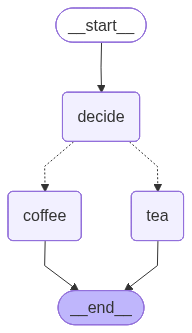

In [20]:
# Cell 4: Visualize the Graph (Mermaid output)
mermaid_code = graph.get_graph().draw_mermaid()
display(Image(graph.get_graph().draw_mermaid_png()))


## Testing valid and inputs (with Pydantic)

### PyDantic with valid input

In [21]:
valid_state = DrinkState(name="Sam", drink_choice="coffee")  # No error

### PyDantic with Invalid input ( ERROR EXPECTED )

In [22]:
try:
    invalid_state = DrinkState(name="Sam", drink_choice="juice")
    result_invalid = graph_pydantic.invoke(invalid_state)
except Exception as e:
    print("Pydantic invalid input error:", e)

Pydantic invalid input error: 1 validation error for DrinkState
drink_choice
  Input should be 'decide', 'coffee' or 'tea' [type=literal_error, input_value='juice', input_type=str]
    For further information visit https://errors.pydantic.dev/2.12/v/literal_error


## Testing valid and inputs (with TypeDict)

### TypeDict schema and graph setup

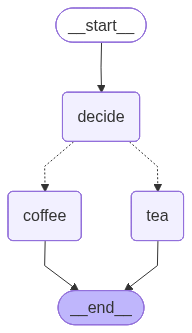

In [23]:

from typing import TypedDict

class DrinkStateDict(TypedDict):
    name: str
    drink_choice: str

builder2 = StateGraph(DrinkStateDict)

builder2.add_node("decide", lambda s: print(f"Morning routine: {s['name']}, choose coffee or tea."))
builder2.add_node("coffee", lambda s: print(f"{s['name']}, enjoy your coffee!"))
builder2.add_node("tea", lambda s: print(f"{s['name']}, enjoy your tea!"))

builder2.add_conditional_edges("decide", 
    lambda s: "coffee" if s["drink_choice"] == "coffee" else "tea",
    ["coffee", "tea"])

builder2.set_entry_point("decide")
graph_typeddict = builder2.compile()

mermaid_code = graph_typeddict.get_graph().draw_mermaid()
display(Image(graph_typeddict.get_graph().draw_mermaid_png()))


### Testing with inputs ( no error for either of the inputs, it even accepted the invalid input)

In [24]:

valid_dict = {"name": "Sam", "drink_choice": "coffee"}
result_dict_valid = graph_typeddict.invoke(valid_dict)
print("TypedDict valid result:", result_dict_valid)

invalid_dict = {"name": "Sam", "drink_choice": "juice"}
result_dict_invalid = graph_typeddict.invoke(invalid_dict)  # No error without manual validation
print("TypedDict invalid accepted (no error):", result_dict_invalid)


Morning routine: Sam, choose coffee or tea.
Sam, enjoy your coffee!
TypedDict valid result: {'name': 'Sam', 'drink_choice': 'coffee'}
Morning routine: Sam, choose coffee or tea.
Sam, enjoy your tea!
TypedDict invalid accepted (no error): {'name': 'Sam', 'drink_choice': 'juice'}


## Testing valid and inputs (with Dataclass)

### Dataclass schema and graph setup

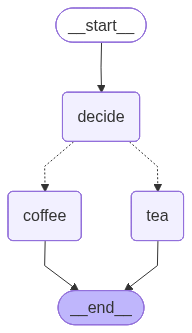

In [25]:

from dataclasses import dataclass

@dataclass
class DrinkStateData:
    name: str
    drink_choice: str

builder3 = StateGraph(DrinkStateData)

builder3.add_node("decide", lambda s: print(f"Morning routine: {s.name}, choose coffee or tea."))
builder3.add_node("coffee", lambda s: print(f"{s.name}, enjoy your coffee!"))
builder3.add_node("tea", lambda s: print(f"{s.name}, enjoy your tea!"))

builder3.add_conditional_edges("decide", 
    lambda s: "coffee" if s.drink_choice == "coffee" else "tea",
    ["coffee", "tea"])

builder3.set_entry_point("decide")
graph_dataclass = builder3.compile()
mermaid_code = graph_dataclass.get_graph().draw_mermaid()
display(Image(graph_dataclass.get_graph().draw_mermaid_png()))


### Testing with inputs ( no error for either of the inputs, it even accepted the invalid input)

In [26]:

valid_dc = DrinkStateData(name="Sam", drink_choice="tea")
result_dc_valid = graph_dataclass.invoke(valid_dc)
print("Dataclass valid result:", result_dc_valid)

invalid_dc = DrinkStateData(name="Sam", drink_choice="juice")
result_dc_invalid = graph_dataclass.invoke(invalid_dc)  # No error without manual validation
print("Dataclass invalid accepted (no error):", result_dc_invalid)


Morning routine: Sam, choose coffee or tea.
Sam, enjoy your tea!
Dataclass valid result: {'name': 'Sam', 'drink_choice': 'tea'}
Morning routine: Sam, choose coffee or tea.
Sam, enjoy your tea!
Dataclass invalid accepted (no error): {'name': 'Sam', 'drink_choice': 'juice'}
